In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

from IPython.display import display, HTML

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys
import pickle
import seaborn as sns
import itertools
from time import time
from tqdm import tqdm_notebook

sys.path.append('..')

import warnings
warnings.filterwarnings("ignore")

In [3]:
from simulations.scenarios import *
from simulations.agent import *
from simulations.utils import Context
from scripts.parse_enron import Message

In [4]:
sns.set_context("paper", font_scale=2)
sns.set_style("white")
sns.set_palette(sns.cubehelix_palette(n_colors=4))
boxplot_kwargs = dict(
    showfliers=False,
    boxprops={'linewidth': 2}, whiskerprops={'linewidth': 2},
    capprops={'linewidth': 3}, medianprops={'linewidth': 3})

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [5]:
parsed_logs_folder = '../data/enron/parsed'
simulation_reports_folder = '../data/reports'
breakpoints_filename = '../settings/breakpoints.txt'

social_graph = pickle.load(open(os.path.join(parsed_logs_folder, "social.pkl"), "rb"))
enron_log = pickle.load(open(os.path.join(parsed_logs_folder, "replay_log.pkl"), "rb"))

In [6]:
image_output_folder = '../images'
!mkdir -p $image_output_folder

### Plotting code

In [7]:
def make_encryption_status_plots(scenario_name, reports, breakpoints=None,
                                 mask_fn=None):
    if breakpoints is None:
        breakpoints = range(len(reports) + 1)
        
    fig, axes = plt.subplots(nrows=5, ncols=2)
    fig.set_figwidth(15)
    fig.set_figheight(30)
    axes = list(itertools.chain.from_iterable(axes))

    for i, (offset, report, ax) in enumerate(
            zip(breakpoints[:-1], reports, axes)):
        if mask_fn is not None:
            mask = mask_fn(report)
        else:
            mask = None
        visualize_encryption_status_history(
            '%s (log chunk @%d)' % (scenario_name, offset),
            report.encryption_status_data,
            report.link_status_data,
            log_size=LOG_CHUNK_SIZE,
            mask=mask,
            ax=ax)
        
def compute_enc_stats_in_batches(enc_status_data, link_status_data,
                                 log_size, batch_size=1000, mask=None):
    batch_stats_data = pd.DataFrame(columns=['Encrypted', 'Plaintext'])
    batch_stats_data.loc[0] = [0., 100.]
    for i in range(batch_size, log_size, batch_size):
        enc_status_batch = enc_status_data.loc[i:i+batch_size].dropna()
        link_status_batch = link_status_data.loc[i:i+batch_size].dropna()
        if mask is not None:
            mask_batch = mask.loc[i:i+batch_size]
            enc_status_batch = enc_status_batch[mask_batch]
            link_status_batch = link_status_batch[mask_batch]

        if len(enc_status_batch) == 0:
            continue

        encrypted_prop = np.mean(enc_status_batch == EncStatus.encrypted) * 100
        stale_prop = np.mean(enc_status_batch == EncStatus.stale) * 100
        
        # Proportion of initial contacts
        plain_status_batch = link_status_batch[enc_status_batch == EncStatus.plaintext]
        greeting_mask = plain_status_batch['greeting'] > 0
        followup_mask = plain_status_batch['followup'] > 0
        greeting_prop = np.sum(greeting_mask & ~followup_mask) \
                        / len(link_status_batch) * 100
        followup_prop = np.sum(followup_mask) / len(link_status_batch) * 100
        
        batch_stats_data.loc[i] = [
            encrypted_prop + stale_prop,
            greeting_prop + followup_prop
        ]

    return batch_stats_data

def visualize_encryption_status_history(
        title, enc_status_data, link_status_data, 
        log_size, batch_size=1000, mask=None, ax=None, 
        legend_kwargs=None, show_title=False, show_legend=False):

    if legend_kwargs is None:
        legend_kwargs = {}
    if ax is None:
        fig, ax = plt.subplots()
    
    batch_stats_data = compute_enc_stats_in_batches(
        enc_status_data, link_status_data, log_size, batch_size, mask=mask)
    batch_stats_data.plot.area(ax=ax)
    
    handles, labels = ax.get_legend_handles_labels()
    legend = ax.legend(handles[::-1], labels[::-1], frameon=True,
                       **legend_kwargs)
    if not show_legend:
        legend.remove()
    if show_title:
        ax.set_title(title)
    ax.set_xlabel("Email sent")
    ax.set_ylabel("Encryption status (%)")
    ax.set_ylim(0, 100)
    
def get_average_diversity_data(report, log_size, batch_size=2500, mask=None):
    
    def collect_data_points(series_dict):
        data_points_by_batch = defaultdict(list)
        for offset in range(0, log_size, batch_size):
            for series in series_dict.values():
                data_slice = series.loc[offset:offset + batch_size]
                if mask is not None:
                    mask_batch = mask.loc[offset:offset+batch_size]
                    data_slice = data_slice[mask_batch]
                data_slice = data_slice.dropna().values
                if len(data_slice) == 0:
                    continue
                flattened_values = []
                for item_list in data_slice:                    
                    flattened_values.extend(item_list)
                if flattened_values:
                    data_point = np.array(flattened_values).mean()
                    data_points_by_batch[offset + batch_size].append(
                        data_point)

        for offset in range(0, log_size, batch_size):
            points = data_points_by_batch[offset + batch_size]
            data_points_by_batch[offset + batch_size] = pd.Series(points)

        result = pd.DataFrame(data_points_by_batch)
        return result

    diversity_data = collect_data_points(
        report.social_evidence_diversity_data)
    
    return diversity_data

def get_average_storage_data(report, log_size, batch_size=2500):
    
    def collect_data_points(series_dict):
        data_points_by_batch = defaultdict(list)
        for offset in range(0, log_size, batch_size):
            for series in series_dict.values():
                data_slice = series.loc[offset:offset + batch_size] \
                            .dropna().values
                if len(data_slice) == 0:
                    continue
                data_point = data_slice.mean() / 1024
                data_points_by_batch[offset + batch_size].append(data_point)

        for offset in range(0, log_size, batch_size):
            points = data_points_by_batch[offset + batch_size]
            data_points_by_batch[offset + batch_size] = pd.Series(points)

        result = pd.DataFrame(data_points_by_batch)
        return result

    bandwidth_data = collect_data_points(report.outgoing_bandwidth_data)
    gossip_storage_data = collect_data_points(report.gossip_store_size_data)
    local_storage_data = collect_data_points(report.local_store_size_data)
    
    return bandwidth_data, gossip_storage_data, local_storage_data

def get_average_enc_status_data(report, cuts, log_size, batch_size=1000, mask=None):
    enc_stats_batches = compute_enc_stats_in_batches(
        report.encryption_status_data, report.link_status_data,
        log_size=log_size, batch_size=batch_size, mask=mask)
    
    if mask is not None:
        enc_status_data = report.encryption_status_data[mask]
    else:
        enc_status_data = report.encryption_status_data
        
    enc_avg_data = pd.DataFrame(columns=['Last batch average', 'Overall average'])
    for cut in cuts:
        # Average of immediate %
        batch_avg = enc_stats_batches['Encrypted'].loc[cut-batch_size]

        # Overall average
        slice_stats = enc_status_data.loc[:cut].value_counts()
        nb_encrypted = slice_stats.get(EncStatus.encrypted) or 0 
        overall_avg = nb_encrypted / slice_stats.sum() * 100

        enc_avg_data.loc[cut] = (batch_avg, overall_avg)

    return enc_avg_data

## Determining parts of the log to simulate

In [8]:
LOG_SIZE = len(enron_log)
LOG_CHUNK_SIZE = 10000
TOTAL_NUM_CHUNKS = 11

In [9]:
with open(breakpoints_filename) as f:
    breakpoints = [int(i) for i in f.readlines()]
breakpoints

[0, 24594, 49188, 73782, 98377, 122971, 147565, 172160, 196754, 221348, 245943]

## Plot private ClaimChain at different starting points in the log

In [10]:
private_reports = []

for i in breakpoints[:-1]:
    report_path = os.path.join(simulation_reports_folder,
                               'private_claimchain_report-%d.pkl' % i)
    with open(report_path, 'rb') as h:
        report = pickle.load(h)
        private_reports.append(report)

Global encrypted traffic

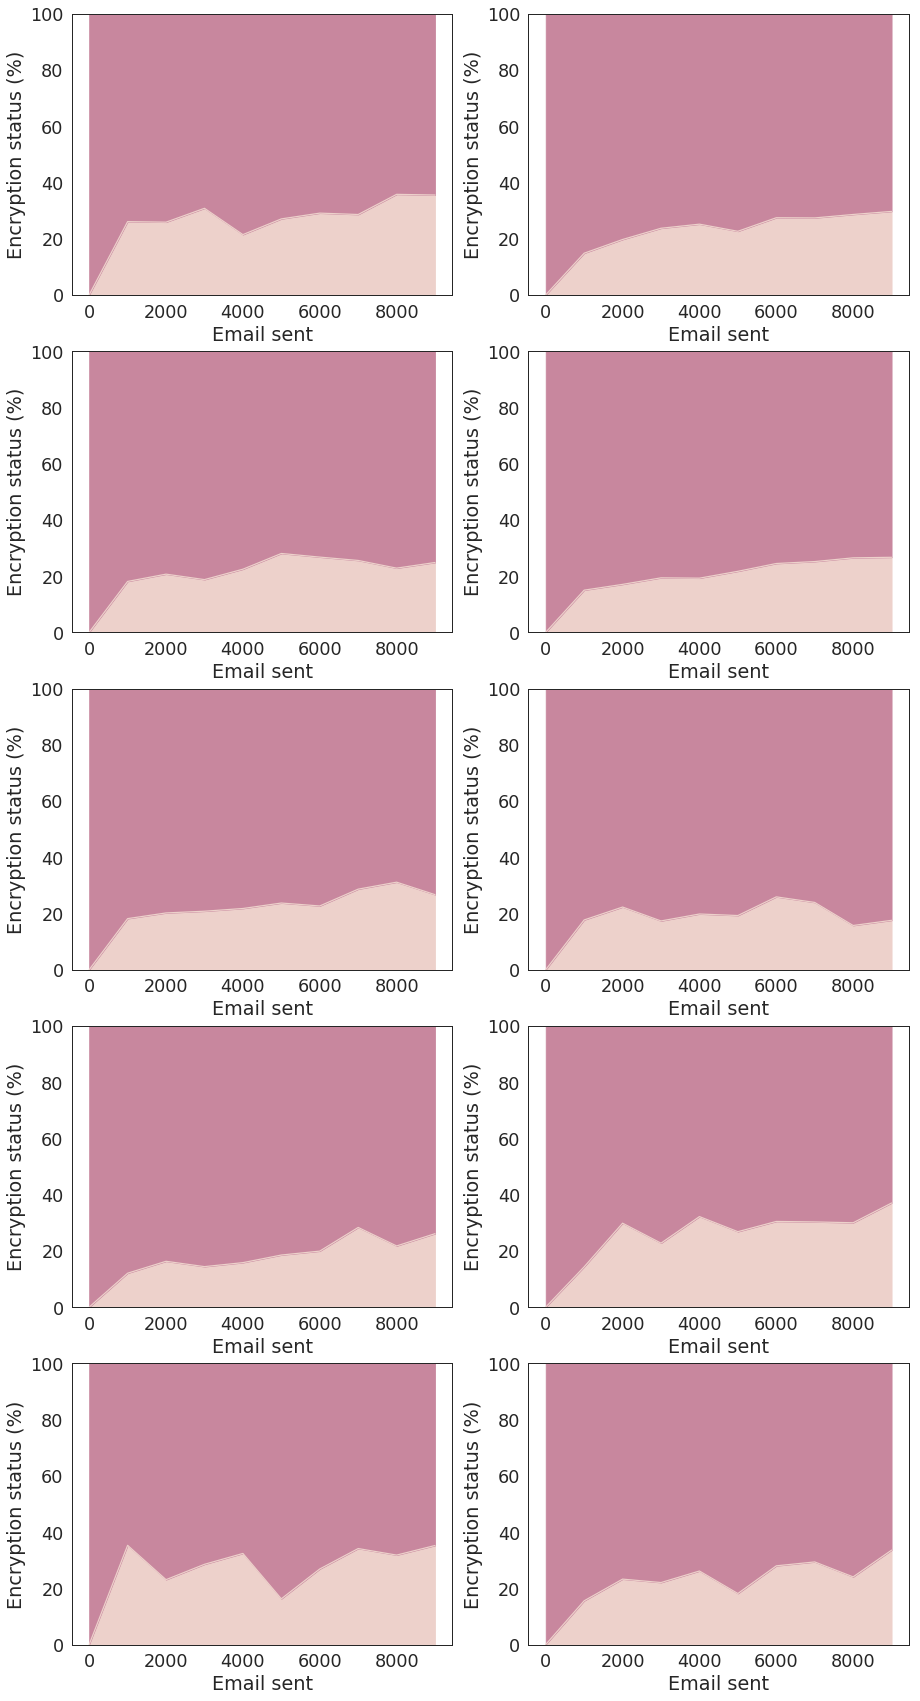

In [11]:
make_encryption_status_plots('Private ClaimChain', private_reports, breakpoints=breakpoints)

Encrypted traffic within the userset

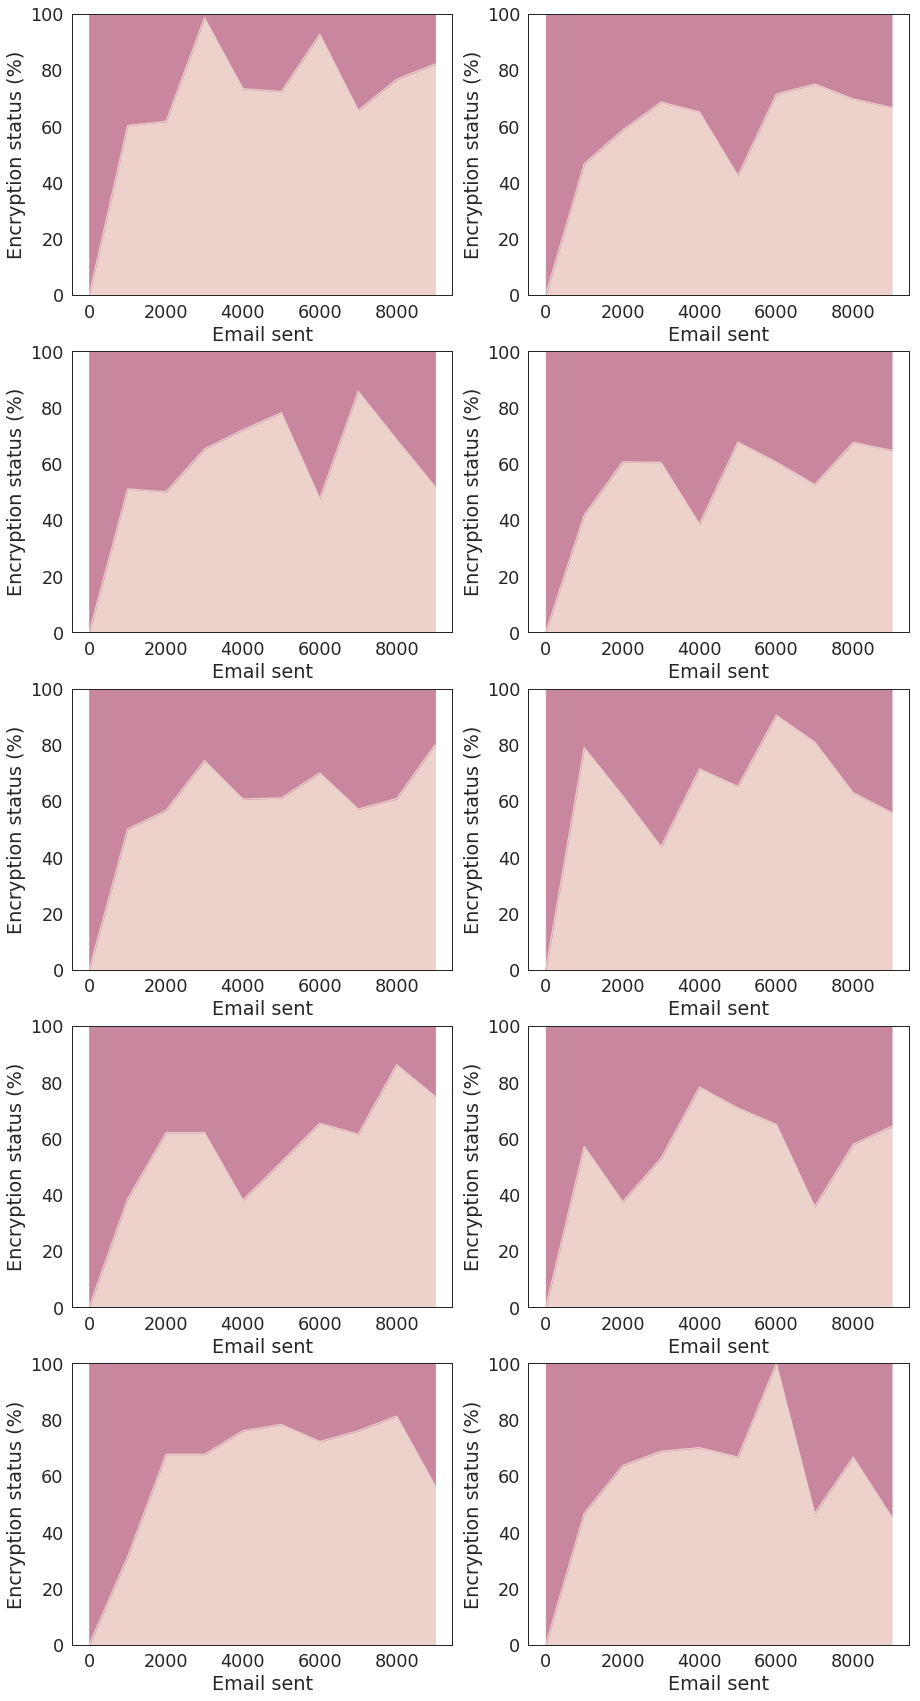

In [12]:
make_encryption_status_plots('Private ClaimChain', private_reports, breakpoints=breakpoints,
                             mask_fn=lambda report: report.participants_type_data == ParticipantsTypes.userset)

### Visualize max time between two messages in the chunk by sender

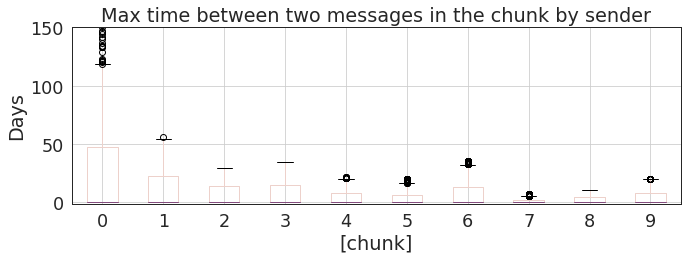

In [13]:
max_delta_send_times = pd.DataFrame(
    columns=['chunk', 'max_delta_per_sender'])

for i, breakpoint in enumerate(breakpoints[:-1]):
    email_time_data = pd.DataFrame(
        [{'email': msg.From, 'mtime': msg.mtime} for msg in enron_log[
            breakpoint:(breakpoint + LOG_CHUNK_SIZE)]])
    time_by_email = email_time_data.groupby('email')
    chunk_max_deltas_data = time_by_email.last() - time_by_email.first()
    chunk_df = pd.DataFrame(
        {'chunk': [i] * len(chunk_max_deltas_data),
         'max_delta_per_sender': chunk_max_deltas_data['mtime'] / 3600 / 24})
    max_delta_send_times = max_delta_send_times.append(
        chunk_df, ignore_index=True)
    
fig, ax = plt.subplots()
max_delta_send_times.boxplot(by='chunk', ax=ax)

plt.suptitle('')
ax.set_title('Max time between two messages in the chunk by sender')
ax.set_ylim(-1, 150)
ax.set_ylabel('Days')

fig.set_figwidth(10)
fig.set_tight_layout(tight=True)

Average encryption proportions

In [14]:
summaries = []
cuts = [2000, 4000, 6000, 8000, 10000]

for i, (offset, report) in enumerate(zip(breakpoints, private_reports)):
    display(HTML('<h4>@%d</h4>' % offset))
    a = get_average_enc_status_data(report, log_size=LOG_CHUNK_SIZE, cuts=cuts)
    b = get_average_enc_status_data(report, log_size=LOG_CHUNK_SIZE,cuts=cuts,
        mask=report.participants_type_data==ParticipantsTypes.userset)
    df = pd.concat({'global': a, 'userset': b}, axis=1)
    summaries.append(df)
    display(df)

global                            userset                
      Last batch average Overall average Last batch average Overall average
2000           26.051282       19.556996          60.240964       41.830065
4000           30.792683       22.780833          98.571429       59.210526
6000           27.024291       22.972040          72.340426       60.858586
8000           28.585961       24.127270          65.714286       62.288136
10000          35.516888       25.674285          82.142857       63.584906

global                            userset                
      Last batch average Overall average Last batch average Overall average
2000           14.822335       11.884205          46.666667       39.361702
4000           23.694779       16.797369          68.571429       49.044586
6000           22.616633       19.166526          42.424242       52.173913
8000           27.373737       21.230536          75.000000       58.630137
10000          29.685917       22.812532          66.666667       60.227273

global                            userset                
      Last batch average Overall average Last batch average Overall average
2000           18.089431       15.055951          50.980392       45.454545
4000           18.737060       17.379063          65.217391       50.370370
6000           28.028747       19.982921          78.125000       57.812500
8000           25.547445       21.520288          85.714286       59.656652
10000          24.819028       21.982315          51.851852       60.000000

global                            userset                
      Last batch average Overall average Last batch average Overall average
2000           14.984709       12.608474          41.666667       32.857143
4000           19.367992       15.390505          60.416667       48.000000
6000           21.690428       17.094308          67.647059       50.000000
8000           25.154004       18.997193          52.542373       51.791531
10000          26.673532       20.501535          64.705882       54.497354

global                            userset                
      Last batch average Overall average Last batch average Overall average
2000           18.162839       13.951067          50.000000       38.636364
4000           20.799180       17.227108          74.358974       50.955414
6000           23.709168       19.049271          61.111111       53.201970
8000           28.647497       20.681996          57.142857       54.980080
10000          26.687764       22.322270          80.000000       58.085809

global                            userset                
      Last batch average Overall average Last batch average Overall average
2000           17.690678       14.553237          78.947368       51.162791
4000           17.339149       17.207183          43.750000       52.500000
6000           19.263158       17.977928          65.217391       58.064516
8000           23.919916       19.712307          80.952381       65.060241
10000          17.561521       19.124449          55.882353       63.436123

global                            userset                
      Last batch average Overall average Last batch average Overall average
2000           12.055974        8.525469          38.461538       32.307692
4000           14.393126       11.939898          62.068966       46.341463
6000           18.518519       13.640437          51.612903       46.285714
8000           28.333333       16.311486          61.538462       51.383399
10000          26.115343       17.823056          75.000000       57.320872

global                            userset                
      Last batch average Overall average Last batch average Overall average
2000           14.316013       14.316239          57.142857       43.333333
4000           22.746331       20.374769          52.941176       43.661972
6000           26.826722       23.458304          70.833333       55.932203
8000           30.293501       25.206557          35.714286       55.263158
10000          37.025316       26.866926          64.285714       56.216216

global                            userset                
      Last batch average Overall average Last batch average Overall average
2000           35.276074       26.161880          31.250000       34.210526
4000           28.527291       25.993249          67.647059       55.660377
6000           16.247379       25.439054          78.260870       62.337662
8000           34.128631       26.702322          76.000000       64.974619
10000          35.215606       28.071272          56.521739       65.254237

global                            userset                
      Last batch average Overall average Last batch average Overall average
2000           15.546218       15.192508          46.666667       36.585366
4000           22.039135       18.929403          68.750000       48.529412
6000           18.134715       20.003452          66.666667       56.363636
8000           29.369183       22.157397          46.666667       55.555556
10000          33.573635       23.499481          45.454545       55.000000

In [15]:
# Stats over all chunks
global_last_batch_df = pd.concat(
    [s['global']['Last batch average'] for s in summaries], axis=1)
userset_last_batch_df = pd.concat(
    [s['userset']['Last batch average'] for s in summaries], axis=1)
global_overall_df = pd.concat(
    [s['global']['Overall average'] for s in summaries], axis=1)
userset_overall_df = pd.concat(
    [s['userset']['Overall average'] for s in summaries], axis=1)

def compute_stats_over_chunks(data):
    return pd.DataFrame({
        'Avg': data.mean(axis=1), 
        'Std': data.std(axis=1),
        'Std * 2.26': data.std(axis=1) * 2.26   # 95% t-val for df=9
    })

display(pd.concat({
    'Last batch average (global)': compute_stats_over_chunks(global_last_batch_df),
    'Last batch average (userset)': compute_stats_over_chunks(userset_last_batch_df),
}, axis=1))

display(pd.concat({
    'Overall average (global)': compute_stats_over_chunks(global_overall_df),
    'Overall average (userset)': compute_stats_over_chunks(userset_overall_df),
}, axis=1))

Last batch average (global)                       \
                              Avg       Std Std * 2.26   
2000                    18.699555  6.933302  15.669262   
4000                    21.843673  4.963282  11.217017   
6000                    22.205976  4.156704   9.394151   
8000                    28.135321  2.916229   6.590678   
10000                   29.287455  6.087063  13.756763   

      Last batch average (userset)                        
                               Avg        Std Std * 2.26  
2000                     50.202312  13.210959  29.856768  
4000                     66.229309  14.375777  32.489256  
6000                     65.423900  11.294362  25.525259  
8000                     63.698560  16.023616  36.213372  
10000                    64.251161  12.140636  27.437838

Overall average (global)                      Overall average (userset)  \
                           Avg       Std Std * 2.26                       Avg   
2000                 15.180603  4.763079  10.764559                 39.573953   
4000                 18.401938  3.919017   8.856979                 50.427412   
6000                 19.878424  3.412446   7.712129                 55.303070   
8000                 21.664735  3.072979   6.944932                 57.958351   
10000                22.867812  3.291244   7.438211                 59.362279   

                            
            Std Std * 2.26  
2000   6.005939  13.573422  
4000   4.508976  10.190286  
6000   4.937770  11.159361  
8000   4.999052  11.297857  
10000  3.781362   8.545877

## Plot public ClaimChain simulation data at one of the points

Pick one chunk

In [16]:
PUBLIC_LOG_SIZE = LOG_CHUNK_SIZE

In [17]:
offset = breakpoints[4]
private_report = private_reports[4]

In [18]:
report_path = os.path.join(simulation_reports_folder,
                           'public_claimchain_report-%d.pkl' % offset)
with open(report_path, 'rb') as h:
    public_report = pickle.load(h)

In [19]:
private_userset_mask = (
        pd.Series(np.array([t.value for t in private_report.participants_type_data]) \
        == ParticipantsTypes.userset.value, index=private_report.participants_type_data.index))

public_userset_mask = (
        pd.Series(np.array([t.value for t in public_report.participants_type_data]) \
        == ParticipantsTypes.userset.value, index=public_report.participants_type_data.index))


Compare public and private versions

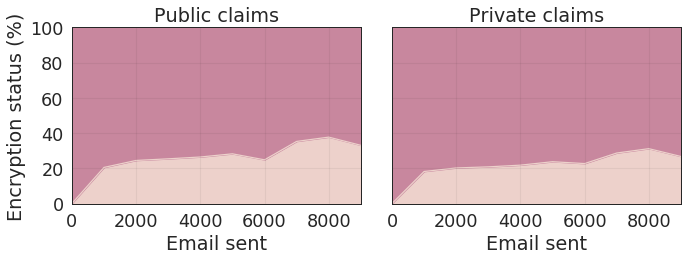

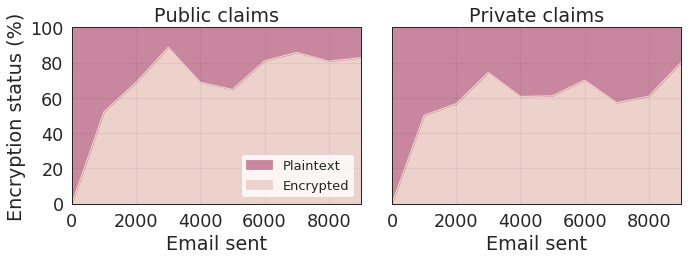

In [20]:
batch_size = 1000

fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True)
fig.set_tight_layout(tight=True)

visualize_encryption_status_history(
    'Public claims',
    public_report.encryption_status_data,
    public_report.link_status_data,
    batch_size=batch_size,
    log_size=PUBLIC_LOG_SIZE,
    show_title=True,
    ax=axes[0])

visualize_encryption_status_history(
    'Private claims',
    private_report.encryption_status_data,
    private_report.link_status_data,
    batch_size=batch_size,
    log_size=PUBLIC_LOG_SIZE,
    show_title=True,
    ax=axes[1])

axes[0].set_xlim(0, PUBLIC_LOG_SIZE-batch_size)
axes[1].set_xlim(0, PUBLIC_LOG_SIZE-batch_size)
fig.set_figwidth(10)

for tick in [20, 40, 60, 80]:
    axes[0].axhline(tick, 0, 8000, alpha=.05, linestyle='-', color='black')
    axes[1].axhline(tick, 0, 8000, alpha=.05, linestyle='-', color='black')
    
for tick in [2000, 4000, 6000, 8000]:
    axes[0].axvline(tick, 0, 100, alpha=.05, linestyle='-', color='black')
    axes[1].axvline(tick, 0, 100, alpha=.05, linestyle='-', color='black')

fig.savefig(os.path.join(image_output_folder, 'enc_status_data_global.pdf'))

fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True)
fig.set_tight_layout(tight=True)

visualize_encryption_status_history(
    'Public claims',
    public_report.encryption_status_data,
    public_report.link_status_data,
    mask=public_userset_mask,
    batch_size=batch_size,
    log_size=PUBLIC_LOG_SIZE,
    show_legend=True,
    show_title=True,
    ax=axes[0],
    legend_kwargs={'fontsize': 13, 'loc': 4})

visualize_encryption_status_history(
    'Private claims',
    private_report.encryption_status_data,
    private_report.link_status_data,
    mask=private_userset_mask,
    batch_size=batch_size,
    log_size=PUBLIC_LOG_SIZE,
    show_title=True,
    ax=axes[1])

axes[0].set_xlim(0, PUBLIC_LOG_SIZE-batch_size)
axes[1].set_xlim(0, PUBLIC_LOG_SIZE-batch_size)
fig.set_figwidth(10)

for tick in [20, 40, 60, 80]:
    axes[0].axhline(tick, 0, 8000, alpha=.05, color='black')
    axes[1].axhline(tick, 0, 8000, alpha=.05, color='black')
    
for tick in [2000, 4000, 6000, 8000]:
    axes[0].axvline(tick, 0, 100, alpha=.05, linestyle='-', color='black')
    axes[1].axvline(tick, 0, 100, alpha=.05, linestyle='-', color='black')
    
fig.savefig(os.path.join(image_output_folder, 'enc_status_data_userset.pdf'))

plt.show()

In [21]:
cuts=[2000, 4000, 6000, 8000, 10000]

print('Public ClaimChain')
a = get_average_enc_status_data(
    public_report, log_size=PUBLIC_LOG_SIZE,
    cuts=cuts)
b = get_average_enc_status_data(
    public_report, log_size=PUBLIC_LOG_SIZE,
    cuts=cuts,
    mask=public_userset_mask)
display(pd.concat({'global': a, 'userset': b}, axis=1))

print('Private ClaimChain')
a = get_average_enc_status_data(
    private_report, log_size=PUBLIC_LOG_SIZE,
    cuts=cuts)
b = get_average_enc_status_data(
    private_report, log_size=PUBLIC_LOG_SIZE,
    mask=private_userset_mask,
    cuts=cuts)
display(pd.concat({'global': a, 'userset': b}, axis=1))

Public ClaimChain


global                            userset                
      Last batch average Overall average Last batch average Overall average
2000           20.480669       14.598540          52.083333       38.888889
4000           25.359343       19.772257          88.571429       56.050955
6000           28.197065       22.264609          64.705882       58.737864
8000           35.238095       24.170802          85.714286       62.903226
10000          33.017876       26.381910          82.758621       66.336634

Private ClaimChain


global                            userset                
      Last batch average Overall average Last batch average Overall average
2000           18.162839       13.951067          50.000000       38.636364
4000           20.799180       17.227108          74.358974       50.955414
6000           23.709168       19.049271          61.111111       53.201970
8000           28.647497       20.681996          57.142857       54.980080
10000          26.687764       22.322270          80.000000       58.085809

## Visualize evidence diversity

In [22]:
private_diversity_data_userset = get_average_diversity_data(
    private_report,  log_size=PUBLIC_LOG_SIZE, batch_size=2500,
    mask=private_userset_mask)

private_diversity_data_global = get_average_diversity_data(
    private_report, log_size=PUBLIC_LOG_SIZE, batch_size=2500)

public_diversity_data_userset = get_average_diversity_data(
    public_report, log_size=PUBLIC_LOG_SIZE, batch_size=2500,
    mask=public_userset_mask)

public_diversity_data_global = get_average_diversity_data(
    public_report, log_size=PUBLIC_LOG_SIZE, batch_size=2500)

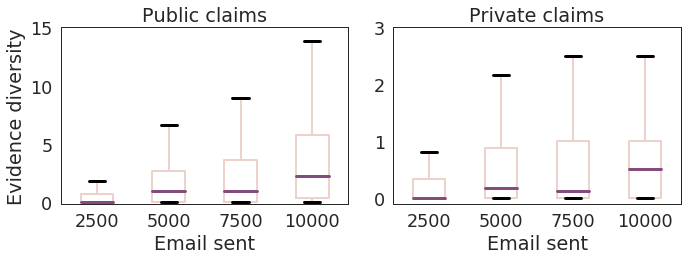

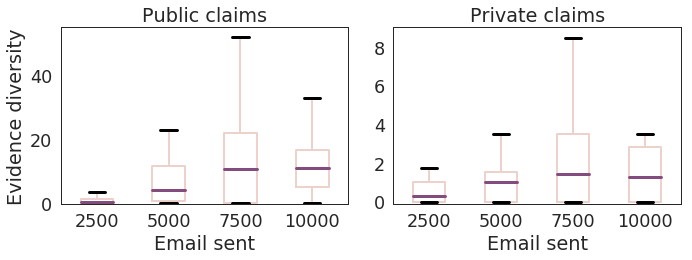

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_tight_layout(tight=True)
fig.set_figwidth(10)

ax = axes[0]
ax.set_xlabel("Email sent")
ax.set_ylabel("Evidence diversity")
ax.set_title('Public claims')
ax.set_ylim(-0.1, 15)

public_diversity_data_global.plot.box(ax=ax, **boxplot_kwargs)

ax = axes[1]
ax.set_xlabel("Email sent")
ax.set_title('Private claims')
ax.set_ylim(-0.1, 3)

private_diversity_data_global.plot.box(ax=ax, **boxplot_kwargs)

fig.savefig(os.path.join(image_output_folder, 'diversity_global.pdf'))

fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_tight_layout(tight=True)
fig.set_figwidth(10)

ax = axes[0]
ax.set_xlabel("Email sent")
ax.set_ylabel("Evidence diversity")
ax.set_title('Public claims')
ax.set_ylim(-0.1, 55)

public_diversity_data_userset.plot.box(ax=ax, **boxplot_kwargs)

ax = axes[1]
ax.set_xlabel("Email sent")
ax.set_title('Private claims')
ax.set_ylim(-0.1, 9)

private_diversity_data_userset.plot.box(ax=ax, **boxplot_kwargs)

fig.savefig(os.path.join(image_output_folder, 'diversity_userset.pdf'))

plt.show()

In [24]:
def get_average_unique_prop_data(report, log_size, batch_size=2500, mask=None):
    
    def collect_data_points(unique_count_series_dict, overall_count_series_dict):
        data_points_by_batch = defaultdict(list)
        for offset in range(0, log_size, batch_size):
            
            def get_batches(series_dict):
                for series in series_dict.values():
                    data_slice = series.loc[offset:offset + batch_size]
                    if mask is not None:
                        mask_batch = mask.loc[offset:offset+batch_size]
                        data_slice = data_slice[mask_batch]

                    data_slice = data_slice.dropna().values
                    if len(data_slice) == 0:
                        continue

                    flattened_values = []
                    for item_list in data_slice:                    
                        flattened_values.extend(item_list)
                    yield flattened_values
            
            batches_gen = zip(get_batches(unique_count_series_dict),
                              get_batches(overall_count_series_dict))
            for unique_count_batch, overall_count_batch in batches_gen:
                data_point = (np.array(unique_count_batch) / np.array(overall_count_batch)).mean()
                data_points_by_batch[offset + batch_size].append(
                    data_point)

        for offset in range(0, log_size, batch_size):
            points = data_points_by_batch[offset + batch_size]
            data_points_by_batch[offset + batch_size] = pd.Series(points)

        result = pd.DataFrame(data_points_by_batch)
        return result

    unique_prop_data = collect_data_points(
        report.unique_evidence_data, report.social_evidence_diversity_data)
    
    return unique_prop_data

In [25]:
unique_prop_data = get_average_unique_prop_data(
    public_report, log_size=PUBLIC_LOG_SIZE, batch_size=PUBLIC_LOG_SIZE)
print('Public global', np.mean(unique_prop_data))

unique_prop_data = get_average_unique_prop_data(
    public_report, log_size=PUBLIC_LOG_SIZE, batch_size=PUBLIC_LOG_SIZE,
    mask=public_userset_mask)
print('Public userset', np.mean(unique_prop_data))

unique_prop_data = get_average_unique_prop_data(
    private_report, log_size=PUBLIC_LOG_SIZE, batch_size=PUBLIC_LOG_SIZE)
print('Private global', np.mean(unique_prop_data))

unique_prop_data = get_average_unique_prop_data(
    private_report, log_size=PUBLIC_LOG_SIZE, batch_size=PUBLIC_LOG_SIZE,
    mask=private_userset_mask)
print('Private userset', np.mean(unique_prop_data))

Public global 10000    0.853301
dtype: float64
Public userset 10000    0.935269
dtype: float64
Private global 10000    0.989118
dtype: float64
Private userset 10000    0.953093
dtype: float64


## Visualize storage

In [26]:
private_bandwidth_data, private_gossip_storage_data, private_local_storage_data = \
    get_average_storage_data(private_report, log_size=PUBLIC_LOG_SIZE, batch_size=2500)
public_bandwidth_data, public_gossip_storage_data, public_local_storage_data = \
    get_average_storage_data(public_report, log_size=PUBLIC_LOG_SIZE, batch_size=2500)

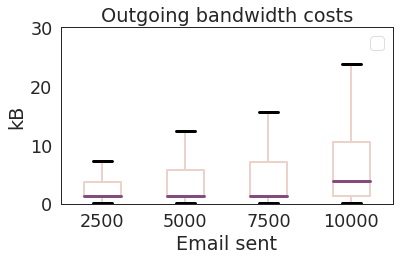

In [27]:
fig, ax = plt.subplots()
fig.set_tight_layout(tight=True)

ax.legend(frameon=True, loc="right bottom")
ax.set_ylabel("kB")
ax.set_xlabel("Email sent")
ax.set_ylim(0, 30)
ax.set_title("Outgoing bandwidth costs")

private_bandwidth_data.plot.box(ax=ax, **boxplot_kwargs)

fig.savefig(os.path.join(image_output_folder, 'private_bandwidth.pdf'))

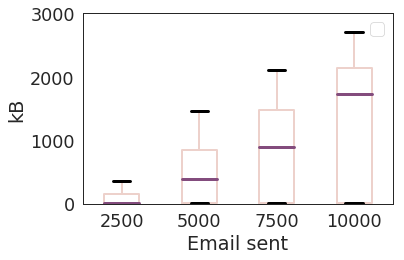

In [28]:
fig, ax = plt.subplots()
fig.set_tight_layout(tight=True)

ax.legend(frameon=True, loc="right bottom")
ax.set_ylabel("kB")
ax.set_xlabel("Email sent")
ax.set_ylim(0, 3000)
public_bandwidth_data.plot.box(ax=ax, **boxplot_kwargs)

fig.savefig(os.path.join(image_output_folder, 'public_bandwidth.pdf'))

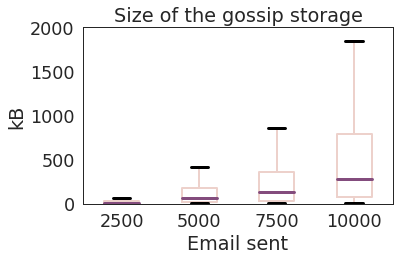

In [29]:
fig, ax = plt.subplots()
fig.set_tight_layout(tight=True)

ax.set_ylabel("kB")
ax.set_xlabel("Email sent")
ax.set_ylim(0, 2000)
ax.set_title("Size of the gossip storage")
private_gossip_storage_data.plot.box(ax=ax, **boxplot_kwargs)

fig.savefig(os.path.join(image_output_folder, 'private_gossip_storage.pdf'))

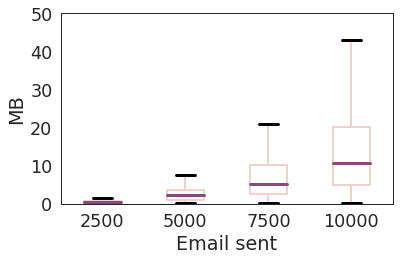

In [30]:
fig, ax = plt.subplots()
fig.set_tight_layout(tight=True)

ax.set_ylabel("MB")
ax.set_xlabel("Email sent")
ax.set_ylim(0, 50.000)
(public_gossip_storage_data / 1024).plot.box(ax=ax, **boxplot_kwargs)

fig.savefig(os.path.join(image_output_folder, 'public_gossip_storage.pdf'))

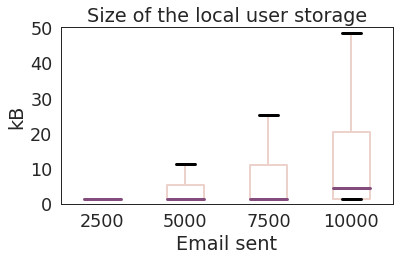

In [31]:
fig, ax = plt.subplots()
fig.set_tight_layout(tight=True)

ax.set_ylabel("kB")
ax.set_xlabel("Email sent")
ax.set_ylim(0, 50)
ax.set_title("Size of the local user storage")
private_local_storage_data.plot.box(ax=ax, **boxplot_kwargs)

fig.savefig(os.path.join(image_output_folder, 'private_local_storage.pdf'))

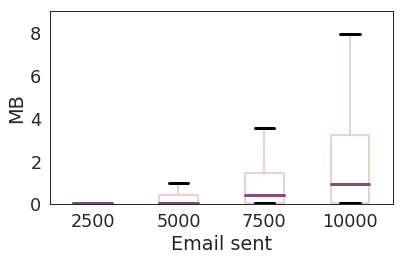

In [32]:
fig, ax = plt.subplots()
fig.set_tight_layout(tight=True)

ax.set_ylabel("MB")
ax.set_xlabel("Email sent")
ax.set_ylim(0, 9.000)
(public_local_storage_data / 1024).plot.box(ax=ax, **boxplot_kwargs)

fig.savefig(os.path.join(image_output_folder, 'public_local_storage.pdf'))